## <u>Customer Segmentation</u>

### Problem Statement
An automobile company has plans to enter new markets with their existing products (P1, P2, P3, P4 and P5). After intensive market research, they’ve deduced that the behavior of new market is similar to their existing market. 

In their existing market, the sales team has classified all customers into 4 segments (A, B, C, D ). Then, they performed segmented outreach and communication for different segment of customers. This strategy has work exceptionally well for them. They plan to use the same strategy on new markets and have identified 2627 new potential customers. 

You are required to help the manager to predict the right group of the new customers.

### Data Description

|Variable|Definition|
|:-------|:---------|
|`ID`|Unique ID|
|`Gender`|Gender of the customer|
|`Ever_Married`|Marital status of the customer|
|`Age`|Age of the customer|
|`Graduated`|Is the customer a graduate?|
|`Profession`|Profession of the customer|
|`Work_Experience`|Work Experience in years|
|`Spending_Score`|Spending score of the customer|
|`Family_Size`|Number of family members for the customer (including the customer)|
|`Var_1`|Anonymised Category for the customer|
|`Segmentation`|(target) Customer Segment of the customer|
  
  
`sample_submission.csv`  
`ID` Unique ID  
`Segmentation` Predicted segment for customers in the test set

### Importing Basic Libraries and Dataset

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# Get training and testing dataset
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

train_df.head(5)

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A


In [3]:
test_df.head(5)

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1
0,458989,Female,Yes,36,Yes,Engineer,0.0,Low,1.0,Cat_6
1,458994,Male,Yes,37,Yes,Healthcare,8.0,Average,4.0,Cat_6
2,458996,Female,Yes,69,No,NaN,0.0,Low,1.0,Cat_6
3,459000,Male,Yes,59,No,Executive,11.0,High,2.0,Cat_6
4,459001,Female,No,19,No,Marketing,NaN,Low,4.0,Cat_6


### EDA (Exploratory Data Analysis)

In [4]:
print(train_df.shape)
print(test_df.shape)

(8068, 11)
(2627, 10)


In [5]:
# merge training and testing dataset to perform EDA
# label(segmentation) is dropped because test_df does not have this column
# original index and id columns are dropped (not necessary in EDA)
full_df = train_df.drop(columns='Segmentation').append(test_df).reset_index().drop(columns=['index', 'ID'])

# validate the shape
full_df.shape

(10695, 9)

In [6]:
full_df

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1
0,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4
1,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4
2,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6
3,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6
4,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6
...,...,...,...,...,...,...,...,...,...
10690,Male,No,29,No,Healthcare,9.0,Low,4.0,Cat_6
10691,Female,No,35,Yes,Doctor,1.0,Low,1.0,Cat_6
10692,Female,No,53,Yes,Entertainment,NaN,Low,2.0,Cat_6
10693,Male,Yes,47,Yes,Executive,1.0,High,5.0,Cat_4


In [7]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10695 entries, 0 to 10694
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Gender           10695 non-null  object 
 1   Ever_Married     10505 non-null  object 
 2   Age              10695 non-null  int64  
 3   Graduated        10593 non-null  object 
 4   Profession       10533 non-null  object 
 5   Work_Experience  9597 non-null   float64
 6   Spending_Score   10695 non-null  object 
 7   Family_Size      10247 non-null  float64
 8   Var_1            10587 non-null  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 752.1+ KB


In [8]:
full_df.describe()

,Age,Work_Experience,Family_Size
count,10695.000000,9597.000000,10247.000000
mean,43.511828,2.619777,2.844052
std,16.774158,3.390790,1.536427
min,18.000000,0.000000,1.000000
25%,30.000000,0.000000,2.000000
50%,41.000000,1.000000,3.000000
75%,53.000000,4.000000,4.000000
max,89.000000,14.000000,9.000000


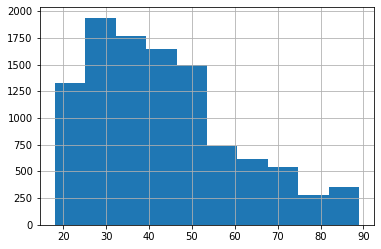

In [9]:
full_df.Age.hist(bins=10)
plt.show()

Based on the histogram, the age distribution is skewed to right (Positively-skewed)

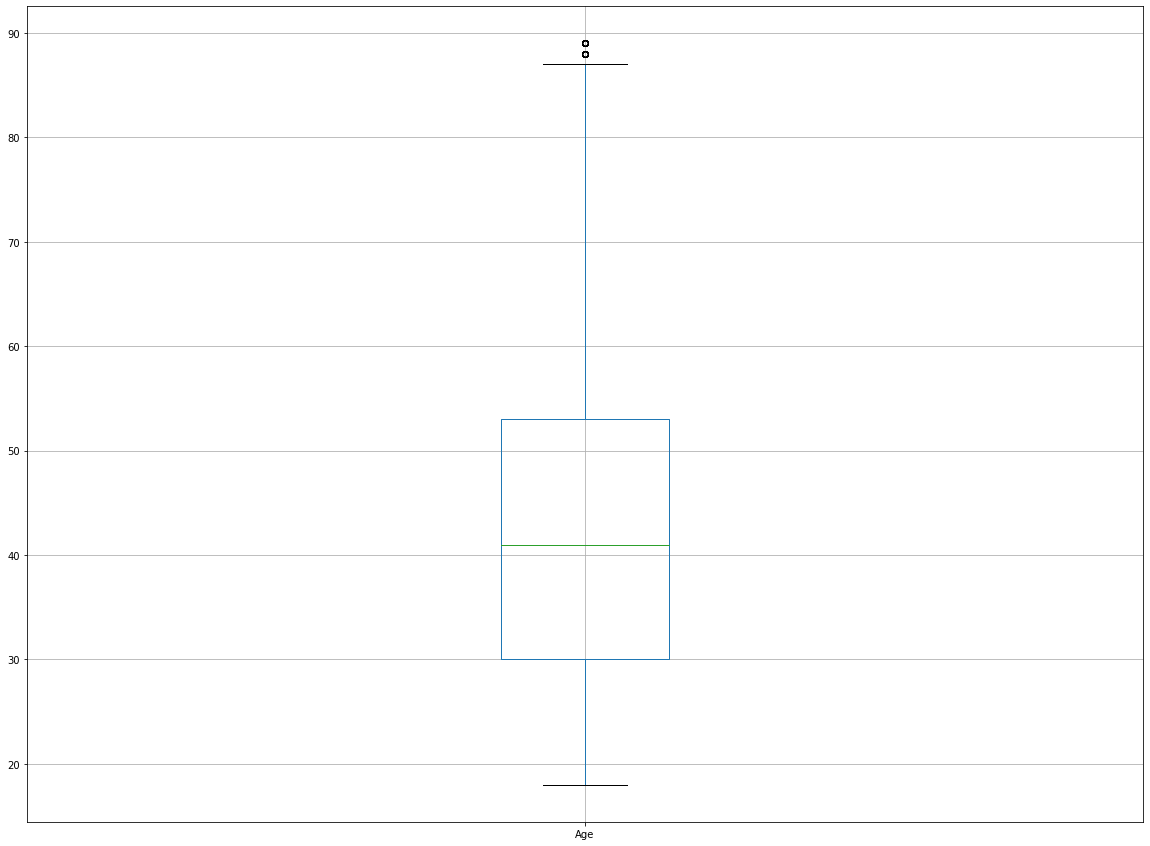

In [10]:
full_df.boxplot(column='Age', return_type='axes', figsize= (20,15));

From the box plot above, looks like `Age` column only consists of upper bound. It's hard to get the counts from there (There might consists of a lot of samples of same value). Therefore, I tried to calculate the percentage of outliers to decide whether it's better to remove them.

In [11]:
full_df.Age.count()

10695

In [12]:
def cal_outliers(df_column):
    q1 = df_column.quantile(0.25)
    q3 = df_column.quantile(0.75)
    
    iqr = q3 - q1
    
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
    
    lower_bound_percent = 100 * df_column[df_column < lower_bound].count() / df_column.count()
    upper_bound_percent = 100 * df_column[df_column > upper_bound].count() / df_column.count()
    
    return lower_bound_percent, upper_bound_percent

In [13]:
_, upper_bound_percent = cal_outliers(full_df.Age)
upper_bound_percent

0.8415147265077139

The upper bound outliers consists of only `0.8415%` of the samples. Hence, it is not necessary to remove them.

I will continue to explore box plots for `Work_Experience` and `Family_Size` column

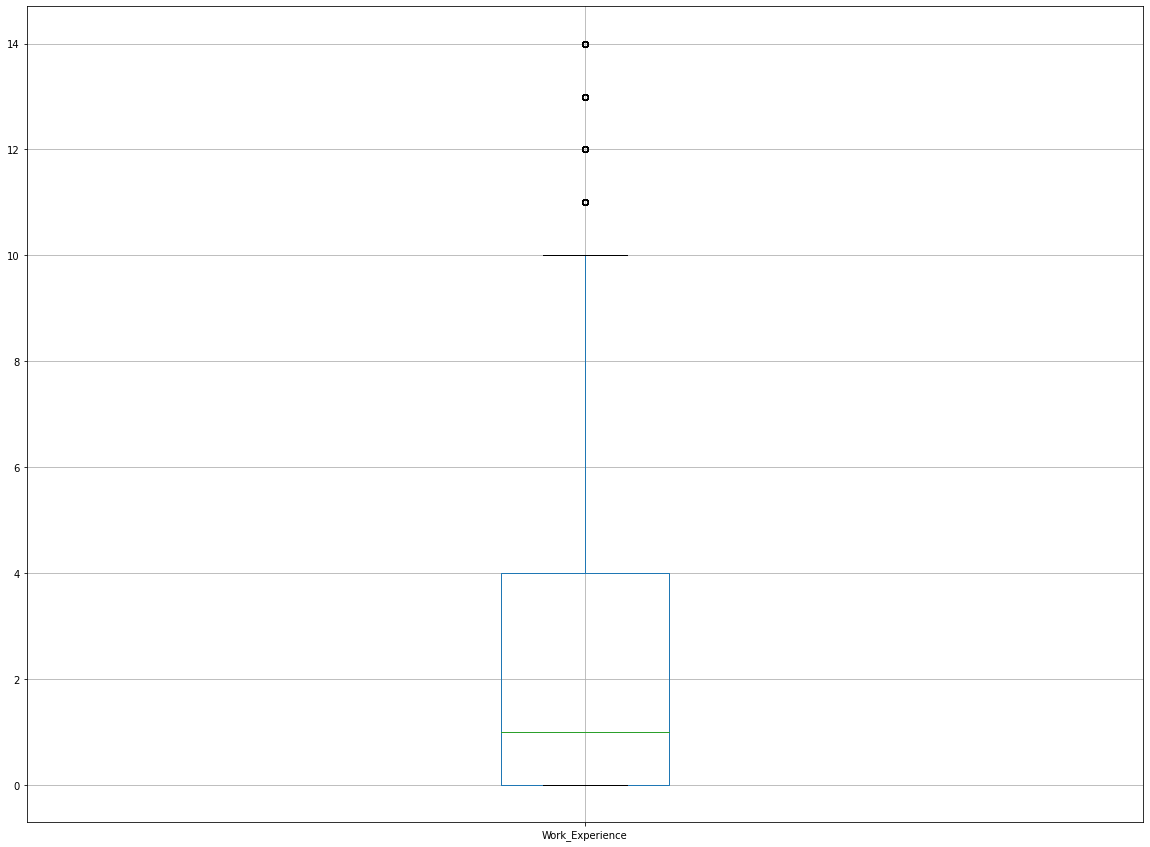

In [14]:
full_df.boxplot(column='Work_Experience', return_type='axes', figsize= (20,15));

In [15]:
_, upper_bound_percent = cal_outliers(full_df.Work_Experience)
upper_bound_percent

2.573720954464937

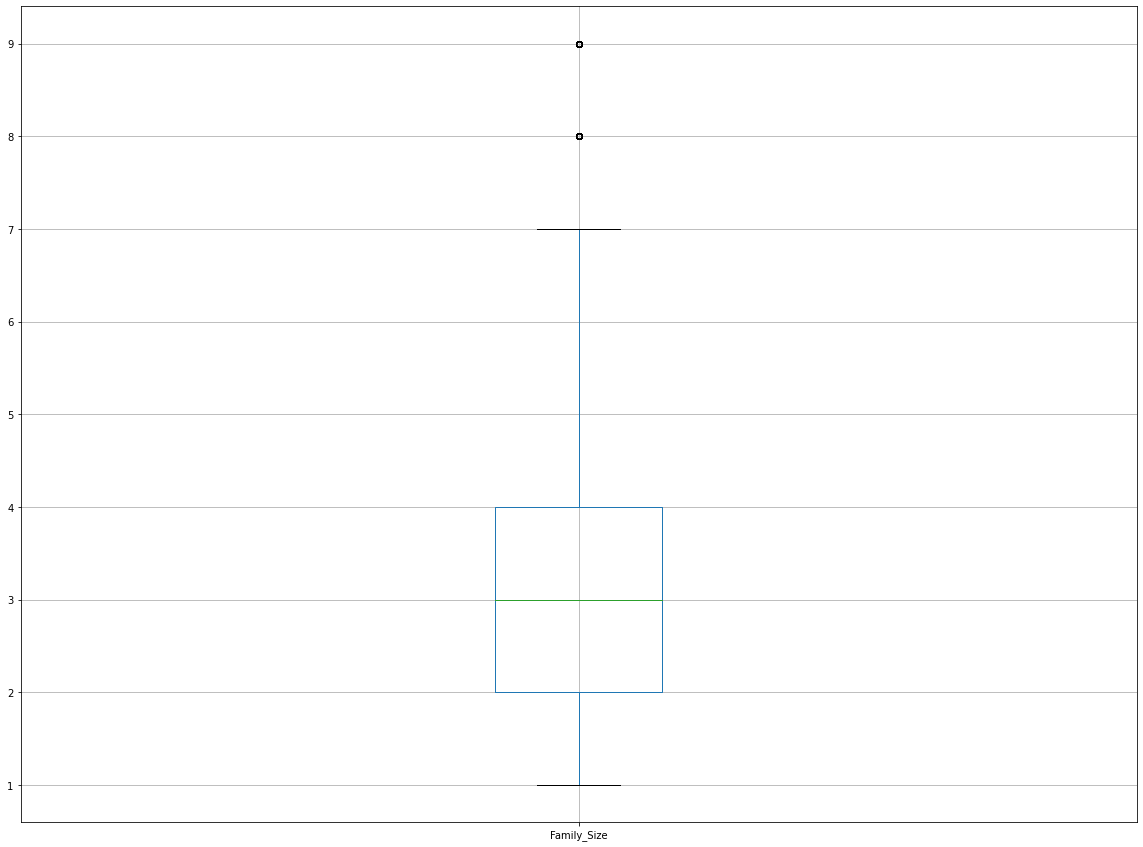

In [16]:
full_df.boxplot(column='Family_Size', return_type='axes', figsize= (20,15));

In [17]:
_, upper_bound_percent = cal_outliers(full_df.Family_Size)
upper_bound_percent

1.219869230018542

<AxesSubplot:>

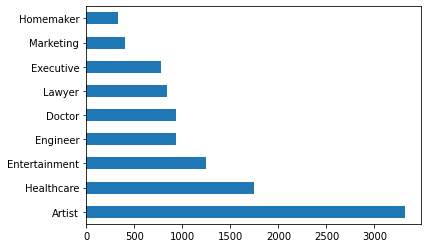

In [18]:
full_df.Profession.value_counts().plot(kind='barh')

<AxesSubplot:>

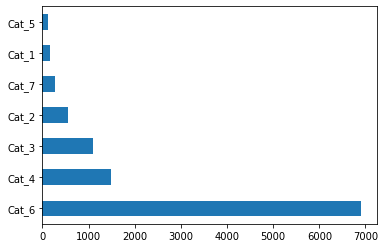

In [19]:
full_df.Var_1.value_counts().plot(kind='barh')

From the bar plot above, `Cat_6` which is the anonymous category of customers is dominating in this column (Greater than the sum of all other categories) 

Now, let's go back to the training data and view the bar plot of the label.

<AxesSubplot:>

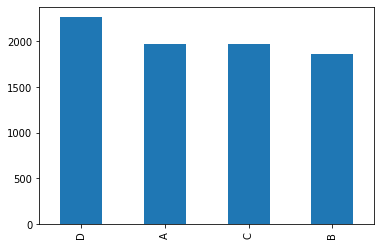

In [20]:
train_df.Segmentation.value_counts().plot(kind='bar')

The number of labels for each category are similar ranging from `1500` to `2300`.

Next, I want to get the number of missing values for the dataset.

In [21]:
train_df.isna().sum()

ID                   0
Gender               0
Ever_Married       140
Age                  0
Graduated           78
Profession         124
Work_Experience    829
Spending_Score       0
Family_Size        335
Var_1               76
Segmentation         0
dtype: int64

In [22]:
train_df.isna().sum()/train_df.shape[0]

ID                 0.000000
Gender             0.000000
Ever_Married       0.017353
Age                0.000000
Graduated          0.009668
Profession         0.015369
Work_Experience    0.102752
Spending_Score     0.000000
Family_Size        0.041522
Var_1              0.009420
Segmentation       0.000000
dtype: float64

After I read through others' works and [explanation](https://www.kaggle.com/code/jassican/rank3-customer-segmentation) about the competition of this dataset, there is a data leakage between the `train_df` and `test_df` where the `ID` columns are the same (Hold about `89%` of the testing dataset)

In [23]:
len(set(train_df.ID.unique()).intersection(set(test_df.ID.unique()))) / test_df.ID.count()

0.8877046060144652

Using the logic of the labels for `test_df` are the same as `train_df` where `ID` column is same, I will predict the same label as if they have the same `iD` regardless of changes in other columns 

### Data Preprocessing

First, I will look back to the `train_df` dataset and split it into two datasets `train_df` and `valid_df` (training and validation set) using `train_test_split` and stratify on `Segmentation` and `Var_1` columns


In [24]:
train_df.Var_1.value_counts(dropna=False)

Cat_6    5238
Cat_4    1089
Cat_3     822
Cat_2     422
Cat_7     203
Cat_1     133
Cat_5      85
NaN        76
Name: Var_1, dtype: int64

The `Var_1` columns contains 76 NaN values so I cannot do stratified sampling on the dataset. Therefore, I decided to drop these rows

In [25]:
train_df = train_df[~train_df.Var_1.isna()]
train_df.Var_1.isna().sum()

0

In [26]:
from sklearn.model_selection import train_test_split

train_df, valid_df = train_test_split(train_df, test_size=0.2, stratify=train_df[['Segmentation','Var_1']], random_state=1)

I have done `train_test_split` using `stratified` sampling technique, let's look are they splitted correctly.

In [27]:
train_df.Segmentation.value_counts(normalize=True)

D    0.280932
A    0.244173
C    0.243860
B    0.231034
Name: Segmentation, dtype: float64

In [28]:
valid_df.Segmentation.value_counts(normalize=True)

D    0.280801
A    0.245153
C    0.243902
B    0.230144
Name: Segmentation, dtype: float64

In [29]:
train_df.Var_1.value_counts(normalize=True)

Cat_6    0.655561
Cat_4    0.136243
Cat_3    0.102769
Cat_2    0.052714
Cat_7    0.025497
Cat_1    0.016737
Cat_5    0.010480
Name: Var_1, dtype: float64

In [30]:
valid_df.Var_1.value_counts(normalize=True)

Cat_6    0.654784
Cat_4    0.136335
Cat_3    0.103189
Cat_2    0.053158
Cat_7    0.025016
Cat_1    0.016260
Cat_5    0.011257
Name: Var_1, dtype: float64

Seems right for me. Now I will split them into `X` (features) and `y` (labels) then put aside `valid_df` dataset for validation purpose.

In [31]:
X_train, y_train = train_df.drop(columns='Segmentation'), train_df.Segmentation
X_valid, y_valid = valid_df.drop(columns='Segmentation'), valid_df.Segmentation

In [32]:
X_train.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1
515,465165,Male,No,61,Yes,Artist,0.0,Low,1.0,Cat_6
1201,459469,Male,Yes,30,Yes,Healthcare,NaN,Low,6.0,Cat_6
6520,464239,Female,Yes,42,No,Artist,0.0,Average,3.0,Cat_6
6396,459670,Female,Yes,39,Yes,Entertainment,7.0,Average,2.0,Cat_6
550,463939,Male,No,26,No,Marketing,0.0,Low,5.0,Cat_6


In [33]:
y_train.head()

515     B
1201    A
6520    A
6396    B
550     D
Name: Segmentation, dtype: object

Now I will move into some data preprocessing techniques. There are some steps to be completed before I move to building the model in a pipeline.
- Impute missing values
- Convert Numerical Data into Categorical Data
- Categorical Data (Ordinal and One Hot)
- Standardization (Numerical Data)

In [34]:
# import libraries
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder;
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

For the `Age` column, instead of passing numerical values into the model, I will like to convert it into categorical values. However, I would like to use custom bin of values `[0,18,25,40,60,100]` instead of auto-cut using `KBinsDiscretizer` provided by `sklearn.preprocessing`. Therefore, I decide to use custom transformer to complete the process.

Note: I have adapted the custom transformer from [StackOverFlow](https://stackoverflow.com/questions/57715314/scikit-learn-transformer-that-bins-data-based-on-user-supplied-cut-points)

In [35]:

class CutTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, bins, right=True, retbins=False,
                 precision=3, include_lowest=False,
                 duplicates='raise'):
        self.bins = bins
        self.right = right
        self.labels = False
        self.retbins = retbins
        self.precision = precision
        self.include_lowest = include_lowest
        self.duplicates = duplicates

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = pd.DataFrame(X)
        for jj in range(X.shape[1]):
            X.iloc[:, jj] = pd.cut(x=X.iloc[:, jj].values, **self.__dict__)
        return X

In [36]:
# verifying purpose
ct = CutTransformer(bins=np.array([0,18,25,40,60,100]))
ct.transform(train_df.Age)

,Age
515,4
1201,2
6520,3
6396,2
550,2
...,...
6151,4
6166,2
1218,2
6928,3


Then, I will start building the preprocessing pipeline as follows:  

|Column|Preprocessing Steps|
|:-------|:---------|
|`Work Experience`, `Family_Size`|Impute missing value using `SimpleImputer` with strategy `median` then perform standardization using `StandardScaler`|
|`Age`|Impute missing value using `SimpleImputer` with strategy `median` then convert into categorical data using custom transformer `CutTransformer`|
|`Gender`,`Ever_Married`,`Graduated`,`Profession`,`Var_1`|Impute missing value using `SimpleImputer` with strategy `most_frequent` then convert into categorical data using `OneHotEncoder`|
|`Spending_Score`|Impute missing value using `SimpleImputer` with strategy `most_frequent` then convert into categorical data with order using `OrdinalEncoder`|

In [37]:
# columns for each preprocessing pipeline
num_features = ['Work_Experience','Family_Size']
age_features = ['Age']
one_hot_features = ['Gender','Ever_Married','Graduated','Profession','Var_1']
ordinal_features  = ['Spending_Score']

# define different preprocessing transformers
cat_imputer = SimpleImputer(strategy='most_frequent')
num_imputer = SimpleImputer(strategy='median')
age_cut_transformer = CutTransformer(bins=np.array([0,18,25,40,60,100]))
one_hot = OneHotEncoder(handle_unknown='error')
ordinal = OrdinalEncoder(handle_unknown='error')
scaler = StandardScaler()

# create four different pipelines for different columns
# columns num_features
num_pipeline = Pipeline(
    steps=[('imputer', num_imputer),('scaler', scaler)]
)

# columns age_features
age_pipeline = Pipeline(
    steps=[('imputer', num_imputer),('age_transformer', age_cut_transformer)]
)

# columns one_hot_features
one_hot_pipeline = Pipeline(
    steps=[('imputer', cat_imputer),('one_hot', one_hot)]
)

# columns ordinal_features
ordinal_pipeline = Pipeline(
    steps=[('imputer', cat_imputer),('ordinal', ordinal)]
)

In [38]:
# merge all four columns into ColumnTransformer
preprocessor = ColumnTransformer(
    transformers = [
        ('num', num_pipeline, num_features),
        ('age', age_pipeline, age_features),
        ('one_hot', one_hot_pipeline, one_hot_features),
        ('ordinal', ordinal_pipeline, ordinal_features)
    ]
)
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['Work_Experience', 'Family_Size']),
                                ('age',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('age_transformer',
                                                  CutTransformer(bins=array([  0,  18,  25,  40,  60, 100])))]),
                                 ['Age']),
                                ('one_hot',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('one_

In [39]:
# check the result
pd.DataFrame(preprocessor.fit_transform(X_train))

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,-0.754016,-1.233544,4.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0
1,-0.449523,2.090535,2.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0
2,-0.754016,0.096088,3.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.377433,-0.568728,2.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,-0.754016,1.425720,2.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6388,-0.449523,-0.568728,4.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6389,1.681925,0.760904,2.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
6390,-0.449523,0.760904,2.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0
6391,-0.449523,0.760904,3.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0


### Model Training and Evaluation

I will choose few classification model and then evaluate their performances. The performance metric of this question will be `accuracy`. In this case, I will use `Logistic Regression`, `Decision Tree`, `Random Forest` and `Voting` classifiers

In [40]:
# import libraries
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost.sklearn import XGBClassifier

In [41]:
# initialise all classifiers
log_cf = LogisticRegression(random_state=1)
dec_cf = DecisionTreeClassifier(random_state=1)
rand_cf = RandomForestClassifier(random_state=1)
vote_cf = VotingClassifier([('log_cf', log_cf),('dec_cf', dec_cf),
                            ('rand_cf', rand_cf)], voting='hard')
xgb_cf = XGBClassifier(random_state=1)

In [42]:
# Make a pipeline for each classifier
log_pipeline = Pipeline(
    steps=[('preprocessor', preprocessor),('log_cf', log_cf)]
)

dec_pipeline = Pipeline(
    steps=[('preprocessor', preprocessor),('dec_cf', dec_cf)]
)

rand_pipeline = Pipeline(
    steps=[('preprocessor', preprocessor),('rand_cf', rand_cf)]
)

vote_pipeline = Pipeline(
    steps=[('preprocessor', preprocessor),('vote_cf', vote_cf)]
)

xgb_pipeline = Pipeline(
    steps=[('preprocessor', preprocessor),('xgb_cf', xgb_cf)]
)

In [43]:
# accuracy for logistic regression pipeline
log_pipeline.fit(X_train, y_train)
log_pipeline.score(X_valid, y_valid)

c:\users\chin\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.5146966854283928

In [44]:
# accuracy for decision tree pipeline
dec_pipeline.fit(X_train, y_train)
dec_pipeline.score(X_valid, y_valid)

0.44152595372107567

In [45]:
# accuracy for decision tree pipeline
rand_pipeline.fit(X_train, y_train)
rand_pipeline.score(X_valid, y_valid)

0.474671669793621

In [46]:
# accuracy for decision tree pipeline
vote_pipeline.fit(X_train, y_train)
vote_pipeline.score(X_valid, y_valid)

c:\users\chin\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.47592245153220764

`XGB Classifier` is unable to convert label automatically (as in `[A,B,C,D]` to `[0,1,2,3]`, so I use `LabelEncoder` to manually convert it.

In [47]:
from sklearn.preprocessing import LabelEncoder

lbl = LabelEncoder()
y_train = lbl.fit_transform(y_train)
y_valid= lbl.transform(y_valid)

In [48]:
# accuracy for xgb pipeline

xgb_pipeline.fit(X_train, y_train)
xgb_pipeline.score(X_valid, y_valid)

0.5165728580362726

Since that `XGB Classifier` outputs the higher accuracy of it, so I decide to use it as the model. I will combine the full training dataset, then use `GridSearchCV` to search for the optimum hyperparameters for the model.

In [49]:
from sklearn.model_selection import GridSearchCV

X_train_df = train_df.drop(columns=['Segmentation'])
y_train_df = train_df.Segmentation
y_train_df = lbl.transform(y_train_df)

X_train_df, y_train_df

(          ID  Gender Ever_Married  Age Graduated     Profession  \
 515   465165    Male           No   61       Yes         Artist   
 1201  459469    Male          Yes   30       Yes     Healthcare   
 6520  464239  Female          Yes   42        No         Artist   
 6396  459670  Female          Yes   39       Yes  Entertainment   
 550   463939    Male           No   26        No      Marketing   
 ...      ...     ...          ...  ...       ...            ...   
 6151  467638    Male          Yes   71       Yes         Artist   
 6166  462810    Male          Yes   36        No      Executive   
 1218  464293    Male           No   30       Yes     Healthcare   
 6928  466541    Male           No   41       Yes  Entertainment   
 1444  467263  Female           No   32        No      Marketing   
 
       Work_Experience Spending_Score  Family_Size  Var_1  
 515               0.0            Low          1.0  Cat_6  
 1201              NaN            Low          6.0  Cat_6  
 6

In [50]:
# Take a look on the XGB Pipeline
from sklearn import set_config

set_config(display='diagram')
xgb_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Work_Experience',
                                                   'Family_Size']),
                                                 ('age',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('age_transformer',
                                                                   CutTransformer(bins=array([  0,  18,  25,  40,  60, 100])))]),
                                                  ['Age']),
                                                 ('one_...
                               gamma=0, gpu_id=-1, grow_policy='depthwise',
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.300000012, max_bin=256,
                               max_cat_to_onehot=4, max_delta_step=0,
                               max_depth=6, max_leaves=0, min_child_weight=1,
                               missing=nan, monotone_constraints='()',
                               n_estimators=100, n_jobs=0, num_parallel_tree=1,
                               objective='multi:softprob', predictor='auto',
                               random_state=1, reg_alpha=0, ...))])

In [51]:
params={
    'preprocessor__num__imputer__strategy' : ['median','mean'],
    'preprocessor__age__imputer__strategy' : ['median','mean'],
    'preprocessor__age__age_transformer__bins' : [np.array([0, 18, 25, 40, 60, 100]), np.array([0, 30, 41, 53, 100])],
    'xgb_cf__min_child_weight' : [1, 5],
    'xgb_cf__gamma': [0.01, 1],
    'xgb_cf__subsample': [0.6, 0.8, 1.0],
    'xgb_cf__max_depth': [3, 7, 10]
}

In [52]:
final_pipeline = GridSearchCV(estimator=xgb_pipeline, param_grid=params, scoring='accuracy', n_jobs=-1, cv=5, verbose=2)
final_pipeline

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Work_Experience',
                                                                          'Family_Size']),
                                                                        ('age',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('age_transformer',
                                                                                          CutTransformer(bins=array([  0,  18,  25,  40,...
             param_grid={'preprocessor__age__age_transformer__bins': [array([  0,  18,  25,  40,  60, 100]),
                                                                      array([  0,  30,  41,  53, 100])],
                         'preprocessor__age__imputer__strategy': ['median',
                                                                  'mean'],
                         'preprocessor__num__imputer__strategy': ['median',
                                                                  'mean'],
                         'xgb_cf__gamma': [0.01, 1],
                         'xgb_cf__max_depth': [3, 7, 10],
                         'xgb_cf__min_child_weight': [1, 5],
                         'xgb_cf__subsample': [0.6, 0.8, 1.0]},
             scoring='accuracy', verbose=2)

In [53]:
final_pipeline.fit(X_train_df, y_train_df)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Work_Experience',
                                                                          'Family_Size']),
                                                                        ('age',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('age_transformer',
                                                                                          CutTransformer(bins=array([  0,  18,  25,  40,...
             param_grid={'preprocessor__age__age_transformer__bins': [array([  0,  18,  25,  40,  60, 100]),
                                                                      array([  0,  30,  41,  53, 100])],
                         'preprocessor__age__imputer__strategy': ['median',
                                                                  'mean'],
                         'preprocessor__num__imputer__strategy': ['median',
                                                                  'mean'],
                         'xgb_cf__gamma': [0.01, 1],
                         'xgb_cf__max_depth': [3, 7, 10],
                         'xgb_cf__min_child_weight': [1, 5],
                         'xgb_cf__subsample': [0.6, 0.8, 1.0]},
             scoring='accuracy', verbose=2)

In [55]:
final_pipeline.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Work_Experience',
                                                   'Family_Size']),
                                                 ('age',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('age_transformer',
                                                                   CutTransformer(bins=array([  0,  30,  41,  53, 100])))]),
                                                  ['Age']),
                                                 ('one_hot',
                                                  Pipeline(steps=...
                               gamma=1, gpu_id=-1, grow_policy='depthwise',
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.300000012, max_bin=256,
                               max_cat_to_onehot=4, max_delta_step=0,
                               max_depth=3, max_leaves=0, min_child_weight=1,
                               missing=nan, monotone_constraints='()',
                               n_estimators=100, n_jobs=0, num_parallel_tree=1,
                               objective='multi:softprob', predictor='auto',
                               random_state=1, reg_alpha=0, ...))])

In [58]:
final_pipeline.best_params_

{'preprocessor__age__age_transformer__bins': array([  0,  30,  41,  53, 100]),
 'preprocessor__age__imputer__strategy': 'median',
 'preprocessor__num__imputer__strategy': 'mean',
 'xgb_cf__gamma': 1,
 'xgb_cf__max_depth': 3,
 'xgb_cf__min_child_weight': 1,
 'xgb_cf__subsample': 1.0}

In [59]:
final_pipeline.best_score_

0.5296402338975212

In [60]:
intersect = list(set(train_df.ID.unique()).intersection(set(test_df.ID.unique())))
intersect

[466951,
 466955,
 466956,
 466961,
 466966,
 466967,
 466970,
 466971,
 466975,
 466990,
 466996,
 466998,
 466999,
 467008,
 467009,
 467023,
 467044,
 467046,
 467053,
 467058,
 467060,
 467063,
 467073,
 467079,
 467085,
 467088,
 467092,
 467093,
 467098,
 467099,
 467107,
 467111,
 467112,
 467113,
 467116,
 467119,
 467121,
 467125,
 467129,
 467132,
 467136,
 467138,
 467139,
 467143,
 467144,
 467146,
 467147,
 467153,
 467157,
 467159,
 467160,
 467165,
 467167,
 467172,
 467180,
 467183,
 467189,
 459000,
 459001,
 459003,
 459008,
 467201,
 459014,
 459015,
 459016,
 467212,
 467216,
 459026,
 467218,
 459032,
 459033,
 459036,
 467230,
 467232,
 459041,
 467233,
 467235,
 467239,
 459056,
 459057,
 459058,
 459059,
 459061,
 467256,
 459065,
 467263,
 459074,
 459079,
 459080,
 467283,
 459100,
 467296,
 459106,
 467300,
 467301,
 459114,
 459117,
 459118,
 459119,
 467309,
 467311,
 467312,
 467313,
 467318,
 459130,
 467322,
 467325,
 467329,
 459140,
 459143,
 459145,
 

In [61]:
X_test = test_df[~test_df.ID.isin(intersect)]
X_test

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1
0,458989,Female,Yes,36,Yes,Engineer,0.0,Low,1.0,Cat_6
1,458994,Male,Yes,37,Yes,Healthcare,8.0,Average,4.0,Cat_6
2,458996,Female,Yes,69,No,NaN,0.0,Low,1.0,Cat_6
6,459005,Male,Yes,61,Yes,Doctor,5.0,Low,3.0,Cat_6
8,459013,Male,Yes,50,Yes,Artist,2.0,Average,4.0,Cat_6
...,...,...,...,...,...,...,...,...,...,...
2612,467930,Male,Yes,45,Yes,Entertainment,4.0,Average,2.0,Cat_6
2616,467938,Male,Yes,46,Yes,Entertainment,5.0,Low,1.0,Cat_2
2618,467946,Female,Yes,42,Yes,Artist,0.0,Low,2.0,Cat_6
2624,467960,Female,No,53,Yes,Entertainment,NaN,Low,2.0,Cat_6


In [62]:
# verify both length
len(intersect)+ X_test.shape[0], test_df.shape[0]

(2627, 2627)

In [63]:
y_test = final_pipeline.predict(X_test)
y_test = lbl.inverse_transform(y_test)
y_test = pd.DataFrame(data=y_test, columns=['Segmentation'])
y_test

,Segmentation
0,A
1,D
2,B
3,A
4,C
...,...
773,C
774,A
775,C
776,A


In [64]:
result = pd.DataFrame(X_test.ID.reset_index().drop(columns='index')).join(y_test)
result

,ID,Segmentation
0,458989,A
1,458994,D
2,458996,B
3,459005,A
4,459013,C
...,...,...
773,467930,C
774,467938,A
775,467946,C
776,467960,A


In [65]:
leak_data = train_df.loc[train_df.ID.isin(intersect), ['ID', 'Segmentation']].sort_values(by='ID')
leak_data

,ID,Segmentation
7233,459000,C
3062,459001,C
5314,459003,C
7322,459008,B
4270,459014,D
...,...,...
968,467949,D
7567,467950,D
4536,467954,D
5499,467958,A


In [66]:
result = result.append(leak_data, ignore_index=True)

In [67]:
result

,ID,Segmentation
0,458989,A
1,458994,D
2,458996,B
3,459005,A
4,459013,C
...,...,...
2622,467949,D
2623,467950,D
2624,467954,D
2625,467958,A


In [68]:
result.to_csv('Result\Result.csv', index=False)

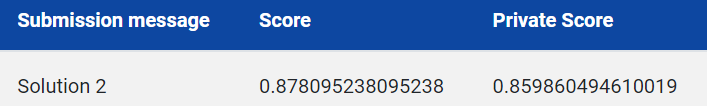

In [69]:
from IPython.display import Image
Image("solution.png")